## Intro
In this tutorial we will see how to fine-tune a sentiment classifier for our own domain, starting with no labeled data

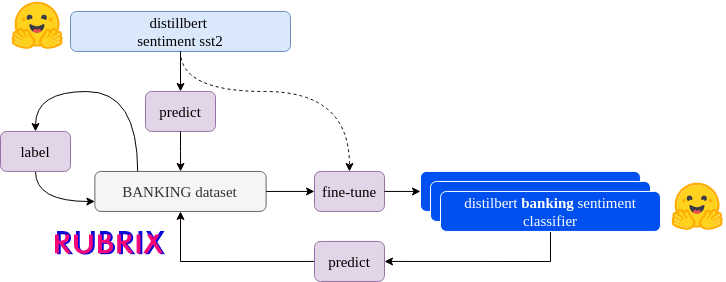

In [4]:
# Install the necessary packages
!pip install torch transformers datasets sklearn ipywidgets -qqq

^C
ERROR: Operation cancelled by user


In [1]:
from datasets import load_dataset

banking_ds = load_dataset('banking77')

to_label1, to_label2 = banking_ds['train'].train_test_split(test_size=.5, seed=42).values()

Using custom data configuration default
Reusing dataset banking77 (/home/ahmed/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/ahmed/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b/cache-3ee5b5f39e7a6029.arrow and /home/ahmed/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b/cache-3613c7618531b684.arrow


In [2]:
from transformers import pipeline

sentiment_classifier = pipeline(
    model='distilbert-base-uncased-finetuned-sst-2-english',
    task='sentiment-analysis',
    return_all_scores=True,
)

to_label1[3]['text'], sentiment_classifier(to_label1[3]['text'])

/home/ahmed/anaconda3/envs/data_struct/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


('Hi, Last week I have contacted the seller for a refund as directed by you, but i have not received the money yet. Please look into this issue with seller and help me in getting the refund.',
 [{'label': 'NEGATIVE', 'score': 0.9934700727462769},
  {'label': 'POSITIVE', 'score': 0.006529912818223238}])

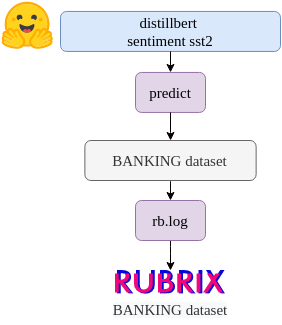

In [3]:
# define a prediction function
def predict(examples):
    return {"predictions": sentiment_classifier(examples['text'], truncation=True)}
    
to_label1 = to_label1.map(predict, batched=True, batch_size=4)

Parameter 'function'=<function predict at 0x7fd7f7d415e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1251 [00:00<?, ?ba/s]

In [4]:
import rubrix as rb

# Create records
# The following code builds a list of Rubrix Records with the predictions
records = []
for example in to_label1.shuffle():
    record = rb.TextClassificationRecord(
        text=example['text'],
        metadata={'category': example['label']},
        prediction=[(pred['label'], pred['score']) for pred in example['predictions']],
        prediction_agent='distilbert-base-uncased-finetuned-sst-2-english',
    )
    records.append(record)

In [5]:
records

[TextClassificationRecord(text='Do you charge extra for exchanging currencies?', inputs={'text': 'Do you charge extra for exchanging currencies?'}, prediction=[('NEGATIVE', 0.9953809976577759), ('POSITIVE', 0.004619020503014326)], prediction_agent='distilbert-base-uncased-finetuned-sst-2-english', annotation=None, annotation_agent=None, multi_label=False, explanation=None, id=None, metadata={'category': 31}, status='Default', event_timestamp=None, metrics=None, search_keywords=None),
 TextClassificationRecord(text="I'm going on holiday to France for 6 weeks with my family and the cat, Fluffy.  I just purchased €10,000 from a currency exchange to ensure we don't run short but there appears to be a fee.  What is this for?", inputs={'text': "I'm going on holiday to France for 6 weeks with my family and the cat, Fluffy.  I just purchased €10,000 from a currency exchange to ensure we don't run short but there appears to be a fee.  What is this for?"}, prediction=[('NEGATIVE', 0.985370516777

In [6]:
# Let's retrieve the data using load_dataset and rb.read_datasets
dataset_ds = load_dataset('rubrix/sentiment-banking', split='train')
dataset_rb = rb.read_datasets(dataset_ds, task='TextClassification')

2022-07-18 14:20:44.219 | WARNING  | datasets.builder:_create_builder_config:463 - Using custom data configuration rubrix--sentiment-banking-e19571b6ec244002
2022-07-18 14:20:44.306 | WARNING  | datasets.builder:download_and_prepare:641 - Reusing dataset parquet (/home/ahmed/.cache/huggingface/datasets/rubrix___parquet/rubrix--sentiment-banking-e19571b6ec244002/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


In [7]:
# Log the records to Rubrix and explore the dataset
rb.log(dataset_rb, name='labeling_with_pretrained')

  0%|          | 0/5001 [00:00<?, ?it/s]

5001 records logged to http://localhost:6900/datasets/rubrix/labeling_with_pretrained


BulkResponse(dataset='labeling_with_pretrained', processed=5001, failed=0)

## 3.Fine-tune the pre-trained model

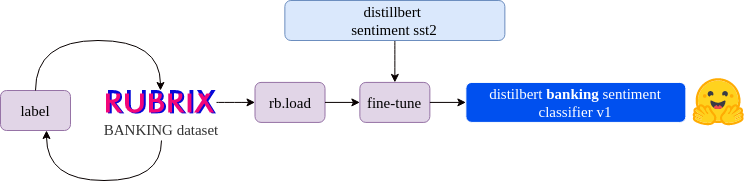

In [14]:
# Let's load the annotations from our dataset using the query parameter from the
# the load mothod
rb_dataset = rb.load(name='labeling_with_pretrained',
                    query='status:Validated')
rb_dataset.to_pandas().head(10)

,text,inputs,prediction,prediction_agent,annotation,annotation_agent,multi_label,explanation,id,metadata,status,event_timestamp,metrics,search_keywords
0,How long does an international transfer take? ...,{'text': 'How long does an international trans...,"[(NEGATIVE, 0.9990523457527161), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,00070829-a80d-4a49-a812-f7bc3d20021a,{'category': 5},Validated,None,{'text_length': 130},None
1,What do I owe for a new card?,{'text': 'What do I owe for a new card?'},"[(NEGATIVE, 0.9941791296005249), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,0012ac3f-c148-411f-8ec0-81e07b6646d8,{'category': 43},Validated,None,{'text_length': 29},None
2,Will I get charged for sending out more cards?,{'text': 'Will I get charged for sending out m...,"[(NEGATIVE, 0.9977859258651733), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,0022000e-7e0e-4af8-b744-97462b3f9bc3,{'category': 39},Validated,None,{'text_length': 46},None
3,What is the charge for using a Top up card in ...,{'text': 'What is the charge for using a Top u...,"[(NEGATIVE, 0.9970560073852539), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,00401b98-8831-4ada-9bc2-11c438751c15,{'category': 57},Validated,None,{'text_length': 53},None
4,Why is my refund not visible on my statement?,{'text': 'Why is my refund not visible on my s...,"[(NEGATIVE, 0.9995235204696655), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,004d4b70-f7f8-49c4-b584-0a2533bdc32e,{'category': 51},Validated,None,{'text_length': 45},None
5,help me link my card,{'text': 'help me link my card'},"[(NEGATIVE, 0.9771099090576172), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,00815371-f6fc-4c58-80c1-8727654f6777,{'category': 13},Validated,None,{'text_length': 20},None
6,I am still waiting for a transfer I did,{'text': 'I am still waiting for a transfer I ...,"[(NEGATIVE, 0.9939014911651611), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,NEGATIVE,rubrix,False,None,008540e9-3ffd-4adb-ab14-05cfc85edee9,{'category': 5},Validated,None,{'text_length': 39},None
7,"I need my PIN, where is it?","{'text': 'I need my PIN, where is it?'}","[(NEGATIVE, 0.9995405673980713), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,NEGATIVE,rubrix,False,None,008d3182-4d92-4f97-b7bd-fdf61c574c6b,{'category': 38},Validated,None,{'text_length': 27},None
8,Where can I go to find out how to verify my id...,{'text': 'Where can I go to find out how to ve...,"[(NEGATIVE, 0.9992928504943848), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,008f6e3e-d797-4c25-ac9d-50627e604200,{'category': 69},Validated,None,{'text_length': 53},None
9,How long should I wait for top up go go through ?,{'text': 'How long should I wait for top up go...,"[(NEGATIVE, 0.9990779161453247), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,00987c95-767b-4f11-b924-609b5266cfdb,{'category': 47},Validated,None,{'text_length': 49},None


In [9]:
train_ds = rb_dataset.prepare_for_training()

In [10]:
from transformers import AutoTokenizer

# Tokenize our datasets
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_train_ds = train_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
# Split the data into a training and evaluation set
train_dataset, eval_dataset = tokenized_train_ds.train_test_split(test_size=.2, seed=42).values()

## Train Our Sentiment Classifier

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [13]:
# Let's download our packages
import numpy as np
from transformers import Trainer
from datasets import load_metric
from transformers import TrainingArguments

training_args = TrainingArguments(
    'distilbert-base-uncased-sentiment-banking',
    evaluation_strategy='epoch',
    logging_steps=30
)

metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
#trainer.train()

In [15]:
help(trainer)

Help on Trainer in module transformers.trainer object:

class Trainer(builtins.object)
 |  Trainer(model: Union[transformers.modeling_utils.PreTrainedModel, torch.nn.modules.module.Module] = None, args: transformers.training_args.TrainingArguments = None, data_collator: Optional[DataCollator] = None, train_dataset: Optional[torch.utils.data.dataset.Dataset] = None, eval_dataset: Optional[torch.utils.data.dataset.Dataset] = None, tokenizer: Optional[transformers.tokenization_utils_base.PreTrainedTokenizerBase] = None, model_init: Callable[[], transformers.modeling_utils.PreTrainedModel] = None, compute_metrics: Optional[Callable[[transformers.trainer_utils.EvalPrediction], Dict]] = None, callbacks: Optional[List[transformers.trainer_callback.TrainerCallback]] = None, optimizers: Tuple[torch.optim.optimizer.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (None, None), preprocess_logits_for_metrics: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] = None)
 |  
 |  Trainer is a simple 

In [16]:
import torch
torch.cuda.is_available()

False